In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from xskillscore import pearson_r, pearson_r_p_value

from unseen import stability

In [57]:
def autocorrelation(da, dim, lag):
    """Calculate the autocorrelation"""

    clean_da = da.dropna(dim=dim)

    N = da[dim].size
    regular_da = clean_da.isel({dim: slice(0, N - lag)})
    shifted_da = clean_da.isel({dim: slice(0 + lag, N)})

    shifted_da[dim] = regular_da[dim]
    r = pearson_r(shifted_da, regular_da, dim)

    return r

### Western Australia

In [2]:
ds_wa = xr.open_dataset(
    "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/growing-season-pr_AGCD-CSIRO_1901-2024_AMJJASO_crops-WA.nc",
    use_cftime=True,
)

In [59]:
df_wa = ds_wa.to_dataframe()
df_wa.index = df_wa.index.year

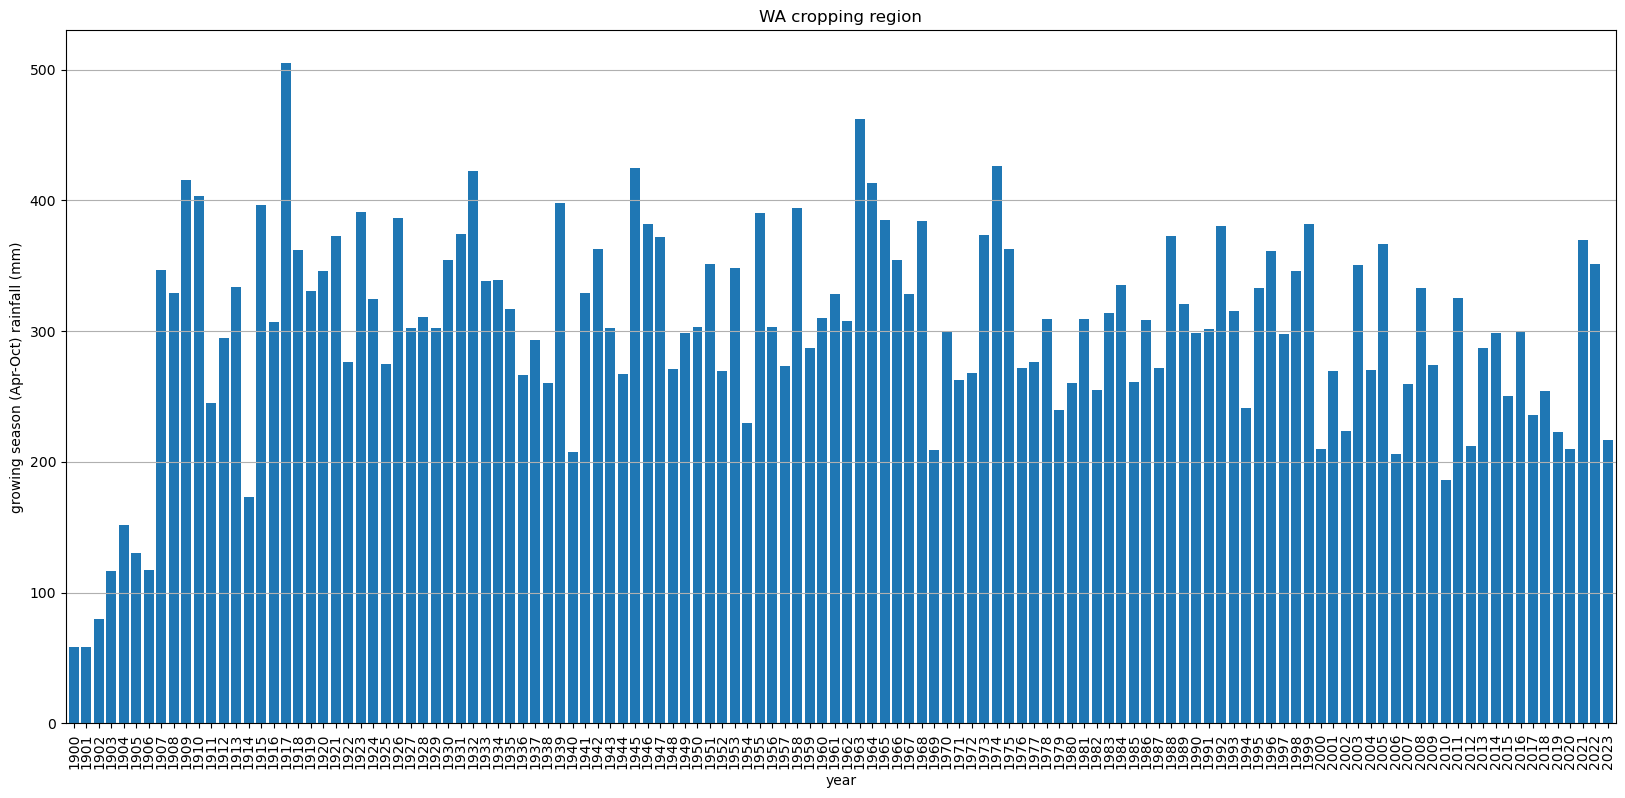

In [60]:
df_wa["pr"].plot.bar(figsize=[20, 9], width=0.8)
plt.ylabel("growing season (Apr-Oct) rainfall (mm)")
plt.xlabel("year")
plt.title("WA cropping region")
plt.grid(axis="y")
plt.show()

In [61]:
ranked_wettest_years_wa = df_wa.sort_values(by="pr", ascending=False)
print(ranked_wettest_years_wa.head(n=10))

              pr
time            
1917  504.980286
1963  462.016937
1974  426.575409
1945  424.499939
1932  422.690735
1909  415.810608
1964  413.161133
1910  403.121033
1939  398.182861
1915  396.709839


In [62]:
ranked_driest_years_wa = df_wa.sort_values(by="pr", ascending=True)
print(ranked_driest_years_wa.head(n=15))

              pr
time            
1901   58.182213
1900   58.438789
1902   79.964096
1903  116.372299
1906  116.883591
1905  130.373642
1904  151.862854
1914  172.760254
2010  185.935745
2006  206.341980
1940  207.488251
1969  208.887268
2020  210.060059
2000  210.141785
2012  211.754364


In [68]:
float(autocorrelation(ds_wa["pr"], "time", 1).data)

0.38478127121925354

In [67]:
float(autocorrelation(ds_wa["pr"], "time", 2).data)

0.38747450709342957

In [69]:
float(autocorrelation(ds_wa["pr"], "time", 3).data)

0.2775730490684509

In [54]:
corr = np.array([])
ntimes = ds_wa["pr"]["time"].size
for start_time in range(ntimes - 10):
    corr = np.append(
        corr,
        float(
            autocorrelation(
                ds_wa["pr"].isel({"time": slice(start_time, start_time + 10)}),
                "time",
                1,
            ).data
        ),
    )

(array([13., 15., 16., 23., 12., 13.,  7.,  7.,  5.,  3.]),
 array([-0.726367  , -0.57118828, -0.41600956, -0.26083084, -0.10565212,
         0.0495266 ,  0.20470532,  0.35988404,  0.51506276,  0.67024148,
         0.8254202 ]),
 <BarContainer object of 10 artists>)

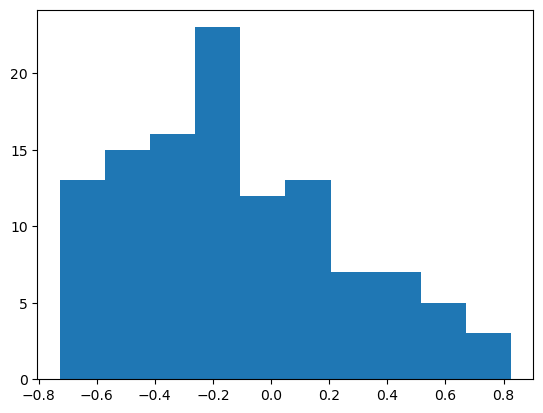

In [55]:
plt.hist(corr)

### South Australia

In [44]:
ds_sa = xr.open_dataset(
    "/g/data/xv83/unseen-projects/outputs/wheatbelt/data/growing-season-pr_AGCD-CSIRO_1901-2024_AMJJASO_crops-SA.nc"
)

In [45]:
df_sa = ds_sa.to_dataframe()
df_sa.index = df_sa.index.year

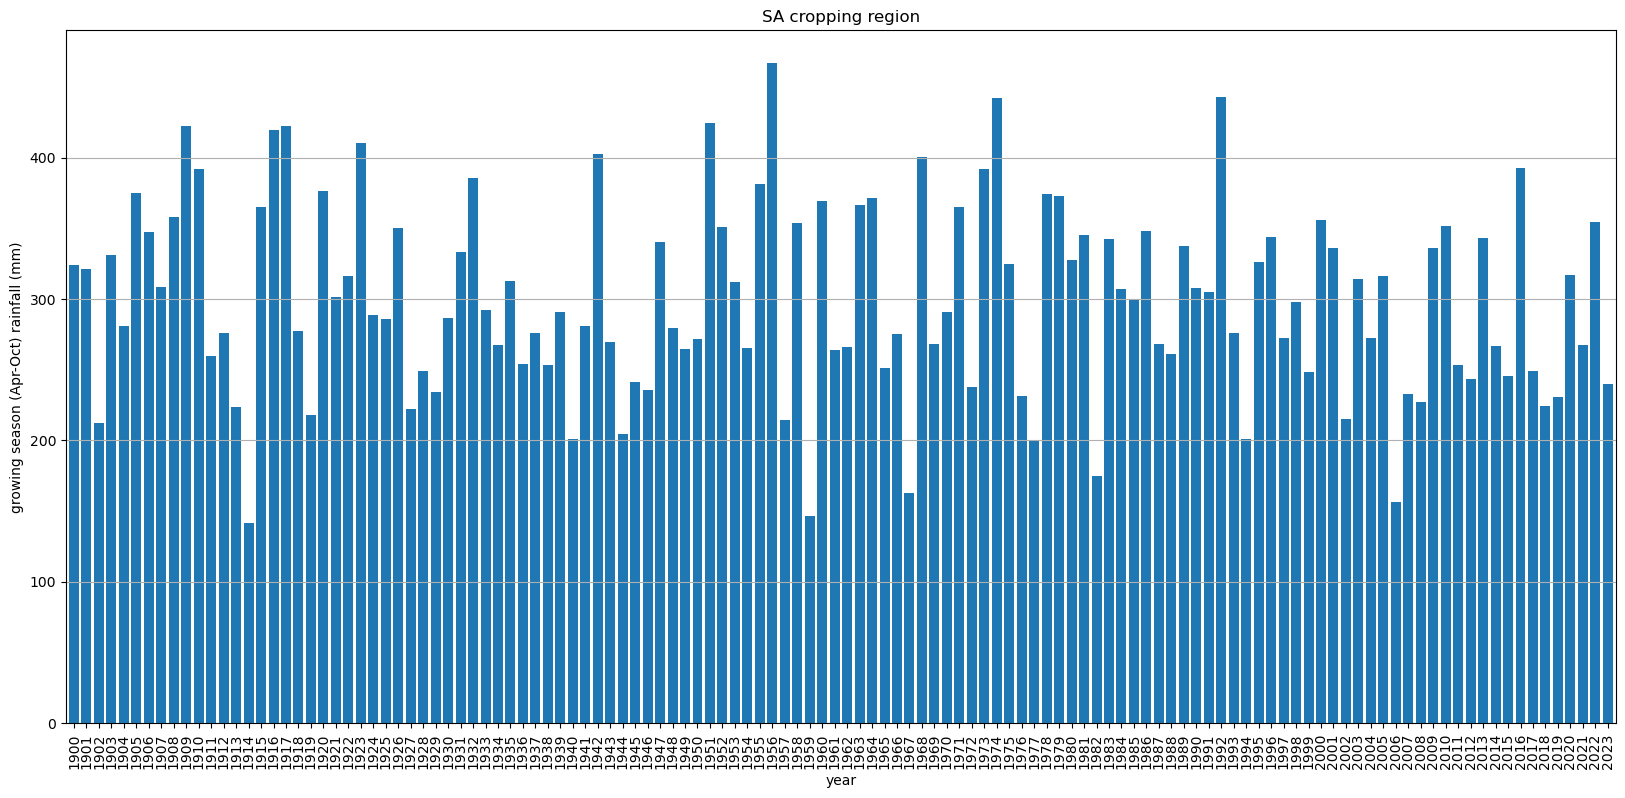

In [46]:
df_sa["pr"].plot.bar(figsize=[20, 9], width=0.8)
plt.ylabel("growing season (Apr-Oct) rainfall (mm)")
plt.xlabel("year")
plt.title("SA cropping region")
plt.grid(axis="y")
plt.show()

In [47]:
ranked_wettest_years_sa = df_sa.sort_values(by="pr", ascending=False)
print(ranked_wettest_years_sa.head(n=10))

              pr
time            
1956  466.671326
1992  442.478943
1974  442.166138
1951  424.150299
1909  422.141327
1917  421.983093
1916  419.719696
1923  410.256012
1942  402.704346
1968  400.018524


In [48]:
ranked_driest_years_sa = df_sa.sort_values(by="pr", ascending=True)
print(ranked_driest_years_sa.head(n=10))

              pr
time            
1914  141.684402
1959  146.223709
2006  156.409714
1967  162.708481
1982  174.716965
1977  199.973206
1940  200.855667
1994  200.926819
1944  204.586685
1902  212.113586


In [49]:
float(autocorrelation(ds_sa["pr"], "time", 1).data)

0.007947145029902458

In [50]:
corr = np.array([])
ntimes = ds_sa["pr"]["time"].size
for start_time in range(ntimes - 10):
    corr = np.append(
        corr,
        float(
            autocorrelation(
                ds_sa["pr"].isel({"time": slice(start_time, start_time + 10)}),
                "time",
                1,
            ).data
        ),
    )

(array([ 4.,  9., 23., 18., 21., 13., 15.,  9.,  1.,  1.]),
 array([-0.6128726 , -0.48064055, -0.3484085 , -0.21617644, -0.08394439,
         0.04828766,  0.18051971,  0.31275176,  0.44498382,  0.57721587,
         0.70944792]),
 <BarContainer object of 10 artists>)

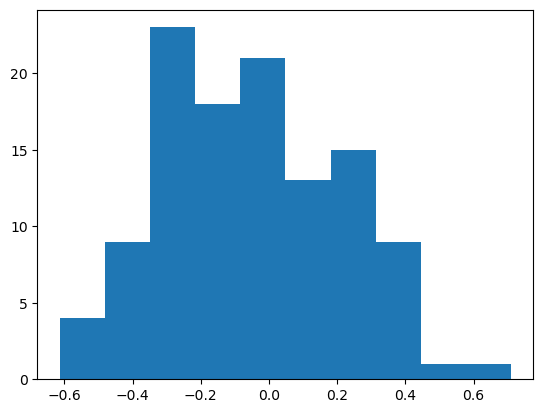

In [51]:
plt.hist(corr)

## Stability

In [3]:
region = "SA"
ds = xr.open_dataset(
    f"../..//outputs/wheatbelt/data/growing-season-pr_AGCD-CSIRO_1901-2024_AMJJASO_crops-{region}.nc",
    use_cftime=True,
)

model = "AGCD-CSIRO"
metric = "growing-season-pr"
units = "total AMJJASO rainfall (mm)"
return_method = "empirical"
ylim = [0, 1000]
uncertainty = True

da = ds.assign_coords({"sample": np.arange(ds.time.size)})
da = da.stack({"sample": ["time"]})
da = da["pr"]

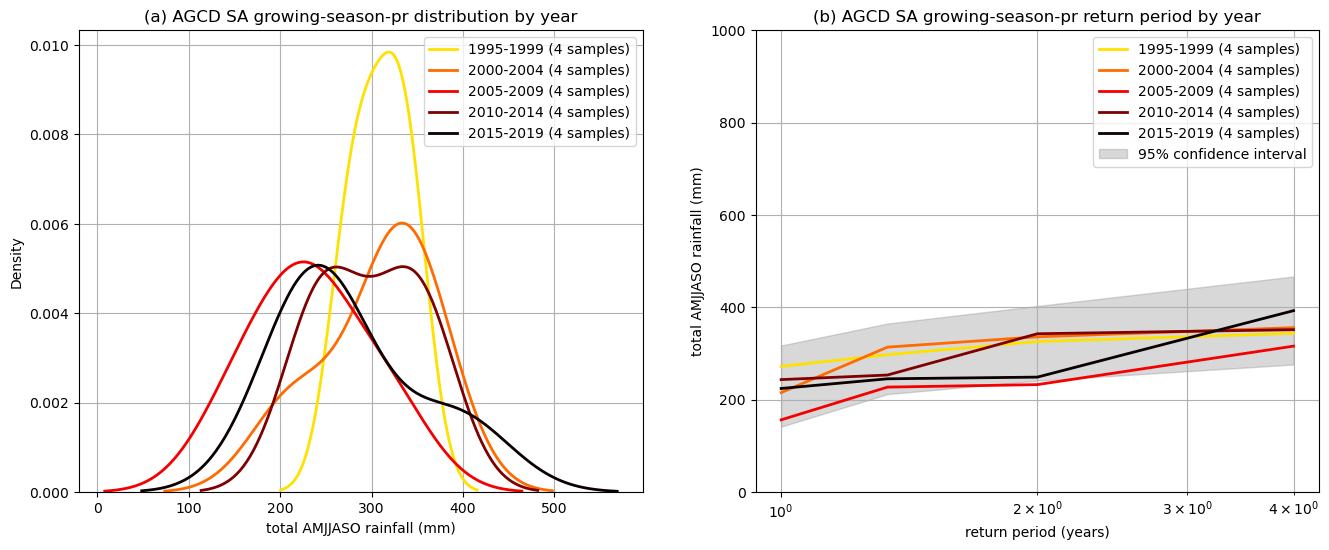

In [4]:
start_years = [1995, 2000, 2005, 2010, 2015]
outfile = f"../../outputs/wheatbelt/figures/stability-test-{return_method}_{metric}_AGCD-CSIRO_1995-2020_AMJJASO_crops-{region}.png"

fig = plt.figure(figsize=[16, 6])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

stability.plot_dist_by_time(ax1, da, metric, start_years, units=units)
stability.plot_return_by_time(
    ax2,
    da,
    metric,
    start_years,
    return_method,
    units=units,
    uncertainty=uncertainty,
    ylim=ylim,
)
ax1.set_title(f"(a) AGCD {region} {metric} distribution by year")
ax2.set_title(f"(b) AGCD {region} {metric} return period by year")
plt.savefig(outfile, bbox_inches="tight", facecolor="white", dpi=200)

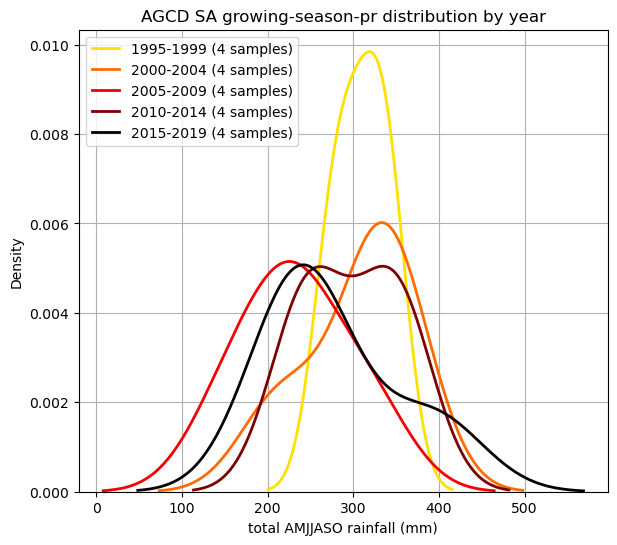

In [5]:
start_years = [1995, 2000, 2005, 2010, 2015]
outfile = f"../../outputs/wheatbelt/figures/stability-test-{return_method}_{metric}_AGCD-CSIRO_1995-2020_AMJJASO_crops-{region}_dist.png"
fig = plt.figure(figsize=[15, 6])
ax1 = fig.add_subplot(121)
stability.plot_dist_by_time(ax1, da, metric, start_years, units=units)
ax1.set_title(f"AGCD {region} {metric} distribution by year")
plt.savefig(outfile, bbox_inches="tight", facecolor="white", dpi=200)

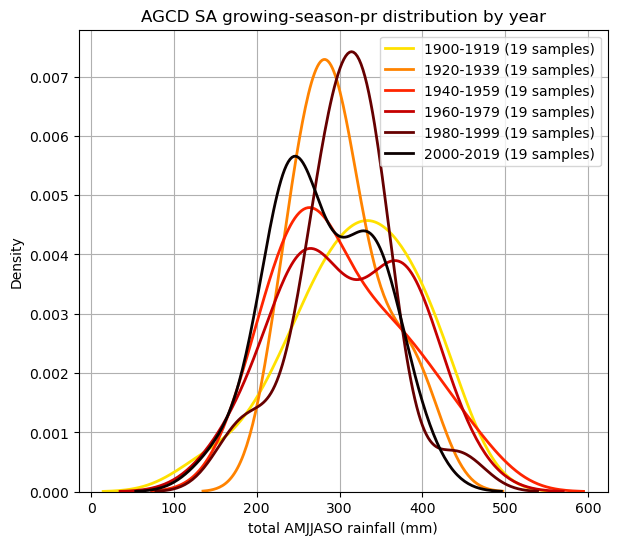

In [6]:
# Modify the start years
start_years = [1900, 1920, 1940, 1960, 1980, 2000]
outfile = f"../../outputs/wheatbelt/figures/stability-test-{return_method}_{metric}_AGCD-CSIRO_1900-2020_AMJJASO_crops-{region}_dist.png"
fig = plt.figure(figsize=[15, 6])
ax1 = fig.add_subplot(121)
stability.plot_dist_by_time(ax1, da, metric, start_years, units=units)
ax1.set_title(f"AGCD {region} {metric} distribution by year")
plt.savefig(outfile, bbox_inches="tight", facecolor="white", dpi=200)